In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "mini_project_2"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

In [3]:
import tensorflow as tf
from sklearn.datasets import fetch_lfw_people
# import fetch_lfw_pairs

#lfw_pairs_train = fetch_lfw_pairs(subset='train')
#lfw_pairs_test = fetch_lfw_pairs(subset='test')

# Set inputs
lfw_people_train = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
lfw_people_test = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X_train = lfw_people_train.images #lfw_pairs_train.data
y_train = lfw_people_train.target #lfw_pairs_train.target
X_test = lfw_people_test.images #lfw_pairs_test.data
y_test = lfw_people_test.target #lfw_pairs_test.target
X_train = X_train.astype(np.float32).reshape(-1, 50*37) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 50*37) / 255.0
#print(X_train.shape)

# Split train into train & valid
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:500], X_train[500:]
y_valid, y_train = y_train[:500], y_train[500:]
#print(lfw_people_train.images.shape)

In [4]:
# Setup of parameters
height = 50
width = 37
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

#def cnn(inputs):
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

with tf.name_scope("conv"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    # ksize = filter size
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding="VALID")
    # The shape was calculated by deeplizard's formula for calculating the dimensions with the input image and the filter dims
    # The result was (n-f+1) x (n-f+1) dimensions.
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 49 * 36])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    y_prob = tf.nn.softmax(logits, name="y_prob")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    loss_summary = tf.summary.scalar('log_loss', loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    #return y_prob, logits, loss, training_op, loss_summary, accuracy, init, saver

In [5]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [6]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

Epoch 0, last batch accuracy: 53.8462%, valid. accuracy: 41.0000%, valid. best loss: 1.824212
Epoch 1, last batch accuracy: 34.6154%, valid. accuracy: 41.0000%, valid. best loss: 1.630989
Epoch 2, last batch accuracy: 48.0769%, valid. accuracy: 51.4000%, valid. best loss: 1.379075
Epoch 3, last batch accuracy: 65.3846%, valid. accuracy: 56.4000%, valid. best loss: 1.125768
Epoch 4, last batch accuracy: 71.1538%, valid. accuracy: 63.4000%, valid. best loss: 0.841883
Epoch 5, last batch accuracy: 88.4615%, valid. accuracy: 75.0000%, valid. best loss: 0.681126
Epoch 6, last batch accuracy: 90.3846%, valid. accuracy: 76.4000%, valid. best loss: 0.604173
Epoch 7, last batch accuracy: 86.5385%, valid. accuracy: 80.2000%, valid. best loss: 0.541183
Epoch 8, last batch accuracy: 98.0769%, valid. accuracy: 82.0000%, valid. best loss: 0.541183
Epoch 9, last batch accuracy: 98.0769%, valid. accuracy: 82.8000%, valid. best loss: 0.507882
Epoch 10, last batch accuracy: 98.0769%, valid. accuracy: 83

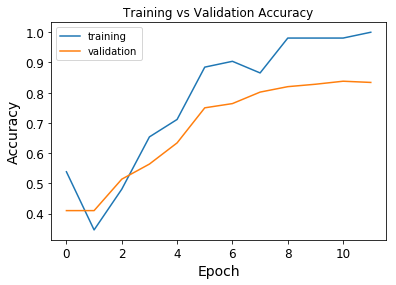

Final accuracy on test set: 93.2453%


In [7]:
import numpy as np
import matplotlib.pyplot as plt
epochs = list()
train_acc = list()
valid_acc = list()

n_epochs = 1000
batch_size = 50
iteration = 0

best_loss_val = np.infty
check_interval = 1
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None

checkpoint_path = "/tmp/mini_project_2.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./mini_project_2"

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        # Split into batches
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            iteration += 1
            # Run training
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            if iteration % check_interval == 0:
                # Check loss val
                loss_val = loss.eval(feed_dict={X: X_valid, y: y_valid})
                # Update best
                if loss_val < best_loss_val:
                    #save_path = saver.save(sess, "./mini_project.ckpt")
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                # O/w continue
                else:
                    checks_since_last_progress += 1
        # Print accuracy
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        epochs = np.append(epochs, epoch)
        train_acc = np.append(train_acc, acc_batch)
        valid_acc = np.append(valid_acc, acc_val)
        print("Epoch {}, last batch accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))
        #save_path = saver.save(sess, "./mini_project.epoch")
        # Early stopping
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    plt.plot(epochs,train_acc,label='training')
    plt.plot(epochs,valid_acc,label='validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    # Test model
    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Final accuracy on test set: {:.4f}%".format(acc_test*100))
    save_path = saver.save(sess, "./mini_project_2_final")

Tests:

Same as Chapt 13 (fmaps 32 64, kern 1, stride 1, relu, maxpool, kern 1 2 2 1, stride 1 1 1 1, relu, fmap 64, poolflat, softmax, Adam):
93.24534%

(Can't increase kern or stride o/w it throws error)

With Leaky_Relu:
lower %

With ELU:
lower %

With Relu and ksize 5:
lower %

With Relu, ksize 3, and GradDesc (at various learning rates including 0.1 and 0.01):
lower %